<a href="https://colab.research.google.com/github/sarthakmhalsekar18/Assignment-hackathon/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [3]:
from google.colab import drive
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted at /content/drive")

Google Drive is already mounted at /content/drive


Import Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Federated Learning Setup

In [5]:
IMG_DIM=48
CLASSES=['angry','disgust','fear','happy','sad','surprise']
NUM_CLASSES=len(CLASSES)
DATA_PATH='/content/drive/MyDrive/Datasets/sarthak dataset'

In [16]:
NUM_CLIENTS=5
CLIENT_EPOCHS=5
NUM_ROUNDS=5
BATCH_SIZE=32

Load and Preprocess Dataset

In [7]:
df=pd.concat([pd.DataFrame({
    'filename':[os.path.join(DATA_PATH,'train',class_name,f)
                for f in os.listdir(os.path.join(DATA_PATH,'train',class_name))
                if f.endswith(('.jpg','.png'))],
    'class':class_name
})for class_name in CLASSES])
print(df.head(2))

                                            filename  class
0  /content/drive/MyDrive/Datasets/sarthak datase...  angry
1  /content/drive/MyDrive/Datasets/sarthak datase...  angry


In [8]:
df_train,df_val=train_test_split(df,test_size=0.3,random_state=42)

In [9]:
print("---Dataset Summary---")
print(f"Total images:{len(df)}")
print(f"Training images(70%):{len(df_train)}")
print(f"Validation images30%):{len(df_val)}")

---Dataset Summary---
Total images:23754
Training images(70%):16627
Validation images30%):7127


 Distribute Data to Clients

In [10]:
client_dfs = []
remaining_df = df_train.copy()

for i in range(NUM_CLIENTS):
    client_share = len(df_train) // NUM_CLIENTS
    if i == NUM_CLIENTS - 1:
        client_df = remaining_df.copy()
    else:
        client_df, remaining_df = train_test_split(
            remaining_df,
            train_size=client_share,
            stratify=remaining_df['class'],
            random_state=42
        )
    client_dfs.append(client_df)
    print(f"\nClient {i} received {len(client_df)} images:")
    print(client_df['class'].value_counts())


Client 0 received 3325 images:
class
happy       1004
sad          672
fear         577
angry        562
surprise     450
disgust       60
Name: count, dtype: int64

Client 1 received 3325 images:
class
happy       1004
sad          672
fear         577
angry        562
surprise     450
disgust       60
Name: count, dtype: int64

Client 2 received 3325 images:
class
happy       1004
sad          671
fear         577
angry        562
surprise     451
disgust       60
Name: count, dtype: int64

Client 3 received 3325 images:
class
happy       1005
sad          672
fear         577
angry        561
surprise     450
disgust       60
Name: count, dtype: int64

Client 4 received 3327 images:
class
happy       1005
sad          672
fear         578
angry        562
surprise     451
disgust       59
Name: count, dtype: int64


Data Generators for Clients

In [11]:
train_clients={}
for i, df in enumerate(client_dfs):
    train_clients[f'client_{i}']=ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    ).flow_from_dataframe(
        dataframe=df,
        x_col='filename',
        y_col='class',
        target_size=(IMG_DIM, IMG_DIM),
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=CLASSES,
        shuffle=True
    )

Found 3325 validated image filenames belonging to 6 classes.
Found 3325 validated image filenames belonging to 6 classes.
Found 3325 validated image filenames belonging to 6 classes.
Found 3325 validated image filenames belonging to 6 classes.
Found 3327 validated image filenames belonging to 6 classes.


Validation Data Generator

In [12]:
val_gen=ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=df_val,
    x_col='filename',
    y_col='class',
    target_size=(IMG_DIM, IMG_DIM),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    shuffle=False
)
print(f"Training clients:{len(train_clients)}")
print(f"Validation samples:{len(df_val)}")

Found 7127 validated image filenames belonging to 6 classes.
Training clients:5
Validation samples:7127


CNN MODEL

In [13]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(IMG_DIM, IMG_DIM, 1), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu', name='last_conv'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Federated Training Loop

In [17]:
round_acc, round_loss = [], []
global_weights = model.get_weights()

for round in range(NUM_ROUNDS):
    print(f"\n=== Round {round+1}/{NUM_ROUNDS} ===")
    client_weights = []

    # Client update
    for client_name, gen in train_clients.items():
        print(f"\nTraining {client_name}...")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_model.fit(gen, epochs=CLIENT_EPOCHS, verbose=1)
        client_weights.append(client_model.get_weights())

    # Federated averaging
    global_weights = [np.mean([w[i] for w in client_weights], axis=0) for i in range(len(global_weights))]
    model.set_weights(global_weights)


    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    round_acc.append(val_acc)
    round_loss.append(val_loss)
    print(f"\n[Validation]Global Model - Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")


=== Round 1/5 ===

Training client_0...
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.2913 - loss: 1.9174
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.3232 - loss: 1.6109
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 262ms/step - accuracy: 0.3811 - loss: 1.5097
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.4096 - loss: 1.4433
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - accuracy: 0.4197 - loss: 1.4036

Training client_1...
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 270ms/step - accuracy: 0.2820 - loss: 1.9201
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 270ms/step - accuracy: 0.3464 - loss: 1.5459
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - accuracy: 0.3856 - loss: 1.4735
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.4128 - loss: 1.4385
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 40s 261ms/step - accuracy: 0.4702 - loss: 1.3451

Training client_2...
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━

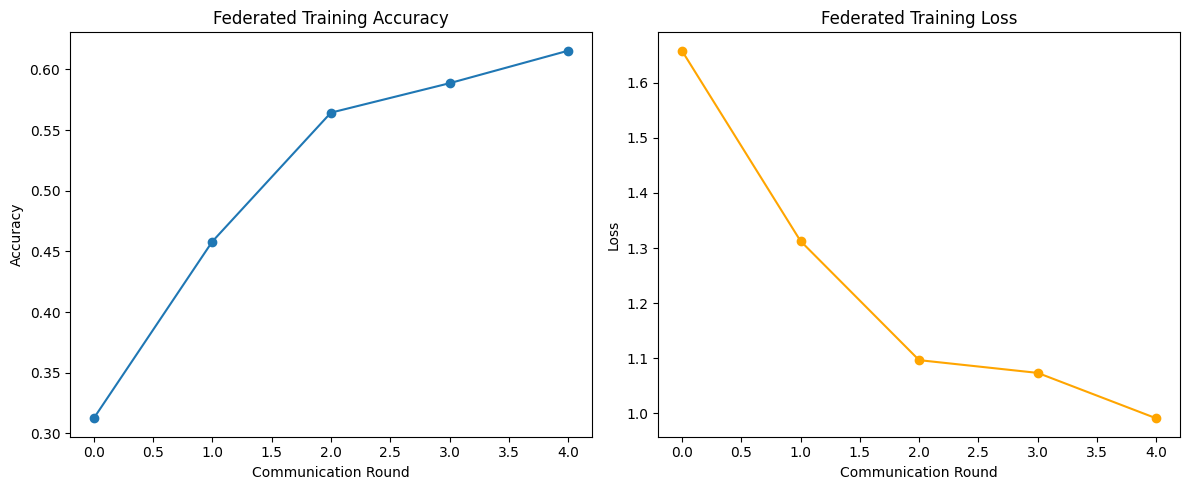

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(round_acc, marker='o')
plt.title('Federated Training Accuracy')
plt.xlabel('Communication Round')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(round_loss, marker='o', color='orange')
plt.title('Federated Training Loss')
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

Test Data

In [19]:
test_df = pd.concat([pd.DataFrame({
    'filename': [os.path.join(DATA_PATH, 'test', class_name, f)
                for f in os.listdir(os.path.join(DATA_PATH, 'test', class_name))
                if f.endswith(('.jpg','.png'))],
    'class': class_name
}) for class_name in CLASSES])
print("\n--- Test Dataset Summary ---")
print(f"Total test images: {len(test_df)}")
print("\nClass distribution in test set:")
print(test_df['class'].value_counts())


--- Test Dataset Summary ---
Total test images: 5945

Class distribution in test set:
class
happy       1774
sad         1247
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64


In [20]:
test_gen=ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_DIM, IMG_DIM),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    shuffle=False
)

Found 5945 validated image filenames belonging to 6 classes.


Test Data accuracy and Loss

In [21]:
test_loss,test_acc=model.evaluate(test_gen,verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 1128s 6s/step - accuracy: 0.4772 - loss: 1.2213

Test Accuracy: 0.6113, Test Loss: 0.9844
